# Multiple Linear Regression

This notebook demonstrates how to implement Multiple Linear Regression from scratch using gradient descent. We'll visualize the data, learning process, and model predictions through interactive plots and animations.

## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Set plot aesthetics
plt.style.use('ggplot')  # Similar to seaborn's whitegrid
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Define Constants

In [3]:
# Dataset path and target column
MLR_DATAPATH = 'data/Student_Performance.csv'
MLR_YCOL = 'Performance Index'

## Multiple Linear Regression Class

In [4]:
class MultipleLinearRegression:
    def __init__(self, X, y, epochs=1000, lr=0.01):
        """
        Initialize the Multiple Linear Regression model.
        
        Parameters:
        -----------
        X : array-like
            Feature matrix with shape (n_samples, n_features)
        y : array-like
            Target vector with shape (n_samples,)
        epochs : int, default=1000
            Number of training epochs
        lr : float, default=0.01
            Learning rate for gradient descent
        """
        self.X = np.array(X)
        self.y = np.array(y)
        self.epochs = epochs
        self.lr = lr
        self.n = self.X.shape[0]
        self.n_features = self.X.shape[1]

        # Initialize weights (including intercept)
        self.beta = np.random.normal(
            0, np.sqrt(2 / self.n), self.X.shape[-1] + 1)
        
        # For tracking learning progress
        self.loss_history = []
        self.beta_history = []

    def forward(self, feat, target):
        """
        Update model parameters based on a single training example.
        
        Parameters:
        -----------
        feat : array-like
            Feature vector
        target : float
            Target value
        """
        # Gradient descent update rule
        self.beta = self.beta + \
            (self.lr * 2 * (target - self.pred(feat)) * self.beta) / self.n

    def pred(self, inp):
        """
        Make a prediction for a single input.
        
        Parameters:
        -----------
        inp : array-like
            Input feature vector
            
        Returns:
        --------
        float
            Predicted value
        """
        # Add a 1 for the intercept term and compute dot product
        return np.dot(np.insert(inp, 0, 1), self.beta)

    def predict(self, X):
        """
        Make predictions for multiple inputs.
        
        Parameters:
        -----------
        X : array-like
            Input feature matrix with shape (n_samples, n_features)
            
        Returns:
        --------
        array-like
            Predicted values
        """
        X = np.array(X)
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.pred(X[i]))
        return np.array(predictions)

    def loss(self):
        """
        Calculate mean squared error loss for the entire dataset.
        
        Returns:
        --------
        float
            Mean squared error
        """
        l = 0
        for i in range(self.n):
            l += (self.y[i] - self.pred(self.X[i])) ** 2

        return l / self.n

    def r2_score(self):
        """
        Calculate the coefficient of determination (R^2 score).
        
        Returns:
        --------
        float
            R^2 score
        """
        y_pred = self.predict(self.X)
        y_mean = np.mean(self.y)
        ss_total = np.sum((self.y - y_mean) ** 2)
        ss_residual = np.sum((self.y - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

    def train(self, verbose=True, save_history=True):
        """
        Train the model using gradient descent.
        
        Parameters:
        -----------
        verbose : bool, default=True
            Whether to show progress bar
        save_history : bool, default=True
            Whether to save loss and parameter history for visualization
        """
        # Reset histories
        self.loss_history = []
        self.beta_history = []

        # Training loop
        for epoch in (pb := tqdm(range(self.epochs), disable=not verbose)):
            # Save current parameters for visualization
            if save_history and epoch % 10 == 0:  # Save every 10 epochs to reduce memory usage
                self.beta_history.append(self.beta.copy())
            
            # Iterate through each sample for stochastic gradient descent
            for i in range(self.n):
                self.forward(self.X[i, :], self.y[i])

                # Calculate and store loss
                current_loss = self.loss()
                if save_history:
                    self.loss_history.append(current_loss)
                    
                # Update progress bar
                if verbose:
                    pb.set_description(f'Epoch: {epoch} Sample: {i} Loss: {current_loss:.4f}')
        
        # Calculate final metrics
        final_loss = self.loss()
        r2 = self.r2_score()
        
        # Display final model information
        print(f'\nTraining complete!')
        print(f'Final loss (MSE): {final_loss:.4f}')
        print(f'R² score: {r2:.4f}')
        
        # Print coefficients
        print('\nModel parameters:')
        print(f'Intercept: {self.beta[0]:.4f}')
        for i in range(1, len(self.beta)):
            print(f'Beta_{i}: {self.beta[i]:.4f}')
            
        return self.beta_history, self.loss_history

## Helper Functions for Visualization

In [5]:
def plot_correlation_matrix(df, target_col):
    """
    Plot correlation matrix for features and target.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    """
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Create heatmap with matplotlib instead of seaborn
    im = plt.imshow(np.ma.array(corr, mask=mask), cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    
    # Add annotations
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            if i < j:  # Only show the lower triangle
                continue
            text = plt.text(j, i, f'{corr.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black")
    
    # Add labels and ticks
    plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(np.arange(len(corr.columns)), corr.columns)
    
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Show correlations with target
    target_corr = df.corr()[target_col].sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    target_corr.drop(target_col).plot(kind='bar')
    plt.title(f'Correlation with {target_col}')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_pairplot(df, target_col):
    """
    Create a pairplot of the dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    """
    if df.shape[1] > 10:  # Too many features for a pairplot
        print("Too many features for a pairplot. Selecting top 5 correlated features.")
        top_corr = df.drop(target_col, axis=1).corrwith(df[target_col]).abs().sort_values(ascending=False)
        top_features = top_corr.head(5).index.tolist()
        features_to_plot = top_features + [target_col]
        df_to_plot = df[features_to_plot]
    else:
        df_to_plot = df
        features_to_plot = df.columns.tolist()
    
    # Create custom pairplot using matplotlib
    n_features = len(features_to_plot)
    fig, axes = plt.subplots(n_features, n_features, figsize=(n_features*2, n_features*2))
    
    # Flatten axes for easier indexing
    if n_features > 1:
        axes = axes.flatten()
    
    # Create scatter plots for each pair of features
    for i, feat_i in enumerate(features_to_plot):
        for j, feat_j in enumerate(features_to_plot):
            ax_idx = i * n_features + j
            
            if n_features == 1:
                ax = axes
            else:
                ax = axes[ax_idx]
                
            if i == j:  # Diagonal: histogram
                ax.hist(df_to_plot[feat_i], bins=20, alpha=0.7, color='royalblue')
                ax.set_title(feat_i)
            else:  # Off-diagonal: scatter plot
                ax.scatter(df_to_plot[feat_j], df_to_plot[feat_i], alpha=0.5, s=5)
                
            if i == n_features - 1:  # Bottom row
                ax.set_xlabel(feat_j)
            else:
                ax.set_xticklabels([])
                
            if j == 0:  # Leftmost column
                ax.set_ylabel(feat_i)
            else:
                ax.set_yticklabels([])
    
    plt.suptitle('Pairwise Relationships', y=1.02)
    plt.tight_layout()
    plt.show()

def create_feature_importances_plot(model, feature_names):
    """
    Create a bar plot of feature importances.
    
    Parameters:
    -----------
    model : MultipleLinearRegression
        Trained model
    feature_names : list
        List of feature names
    """
    # Get coefficients (skip intercept)
    coefficients = model.beta[1:]
    
    # Create a DataFrame with feature names and their coefficients
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    
    # Sort by absolute coefficient value
    coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('AbsCoefficient', ascending=False)
    
    # Create bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'])
    
    # Color positive and negative coefficients differently
    for i, bar in enumerate(bars):
        if coef_df['Coefficient'].iloc[i] < 0:
            bar.set_color('salmon')
        else:
            bar.set_color('skyblue')
    
    plt.title('Feature Importance (Model Coefficients)')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_learning_curve(loss_history):
    """
    Plot the learning curve from training history.
    
    Parameters:
    -----------
    loss_history : list
        List of loss values during training
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Learning Curve')
    plt.xlabel('Update Step')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')  # Log scale often better shows progress
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_weight_trajectory_animation(beta_history, feature_names):
    """
    Create an animation showing the trajectory of weights during training.
    
    Parameters:
    -----------
    beta_history : list
        List of beta values at different points during training
    feature_names : list
        List of feature names
    
    Returns:
    --------
    HTML
        Animation in HTML format
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data
    all_weights = np.array(beta_history)
    weight_names = ['Intercept'] + feature_names
    
    # Set up plot
    def update(frame):
        ax.clear()
        weights = all_weights[frame]
        bars = ax.barh(weight_names, weights)
        
        # Color positive and negative weights differently
        for i, bar in enumerate(bars):
            if weights[i] < 0:
                bar.set_color('salmon')
            else:
                bar.set_color('skyblue')
                
        ax.set_title(f'Weight Evolution (Step {frame*10})')
        ax.axvline(x=0, color='gray', linestyle='--')
        ax.set_xlim(all_weights.min() - 0.1, all_weights.max() + 0.1)
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(beta_history), interval=100)
    plt.close()  # Prevent displaying static plot
    return HTML(anim.to_jshtml())

def plot_residuals(model, X, y):
    """
    Plot residuals analysis for model diagnostics.
    
    Parameters:
    -----------
    model : MultipleLinearRegression
        Trained model
    X : array-like
        Input features
    y : array-like
        Target values
    """
    # Make predictions
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Residuals vs Predicted
    axes[0].scatter(y_pred, residuals, alpha=0.6)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Predicted Values')
    
    # 2. Residuals Distribution
    axes[1].hist(residuals, bins=20, alpha=0.7, density=True)
    
    # Add KDE curve
    from scipy import stats
    x = np.linspace(min(residuals), max(residuals), 100)
    kde = stats.gaussian_kde(residuals)
    axes[1].plot(x, kde(x), 'r-')
    
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Residual Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Residuals Distribution')
    
    # 3. Q-Q Plot for normality check
    from scipy import stats
    stats.probplot(residuals, plot=axes[2])
    axes[2].set_title('Q-Q Plot (Normality Check)')
    
    plt.tight_layout()
    plt.show()

## Load and Prepare Data

In [6]:
try:
    # Load dataset
    df = pd.read_csv(MLR_DATAPATH)
    print(f"Dataset loaded with {df.shape[0]} samples and {df.shape[1]} features")
    
    # Display first few rows
    print(f"\nFirst 5 samples:\n{df.head()}")
    
    # Show basic statistics
    print(f"\nDataset info:")
    display(df.describe())
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"\nMissing values:\n{missing_values[missing_values > 0]}")
    else:
        print("\nNo missing values found.")
    
except FileNotFoundError:
    print(f"Dataset not found at {MLR_DATAPATH}")
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data
    np.random.seed(42)
    n_samples = 200
    n_features = 4
    
    # Create feature names for synthetic data
    feature_names = [f'Feature_{i+1}' for i in range(n_features)]
    
    # Generate random features
    X = np.random.normal(0, 1, (n_samples, n_features))
    
    # Generate target with noise
    true_coef = np.array([3.5, -2.0, 1.5, 0.5])  # True coefficients
    intercept = 5.0
    y = intercept + np.dot(X, true_coef) + np.random.normal(0, 1, n_samples)
    
    # Create a DataFrame
    data = np.column_stack([X, y])
    df = pd.DataFrame(data, columns=feature_names + [MLR_YCOL])
    
    # Display synthetic data information
    print(f"Synthetic dataset created with {n_samples} samples and {n_features} features")
    print(f"True coefficients: {true_coef}")
    print(f"True intercept: {intercept}")
    print(f"\nFirst 5 samples:\n{df.head()}")
    
# Enable this code if you want to test with sklearn's datasets
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
# df = pd.DataFrame(housing.data, columns=housing.feature_names)
# df[MLR_YCOL] = housing.target
# print(f"California Housing dataset loaded with {df.shape[0]} samples and {df.shape[1]-1} features")

Dataset not found at data/Student_Performance.csv
Creating synthetic data for demonstration...
Synthetic dataset created with 200 samples and 4 features
True coefficients: [ 3.5 -2.   1.5  0.5]
True intercept: 5.0

First 5 samples:
   Feature_1  Feature_2  Feature_3  Feature_4  Performance Index
0   0.496714  -0.138264   0.647689   1.523030           9.686360
1  -0.234153  -0.234137   1.579213   0.767435           6.885229
2  -0.469474   0.542560  -0.463418  -0.465730           1.439849
3   0.241962  -1.913280  -1.724918  -0.562288           6.342633
4  -1.012831   0.314247  -0.908024  -1.412304          -1.676088


## Exploratory Data Analysis

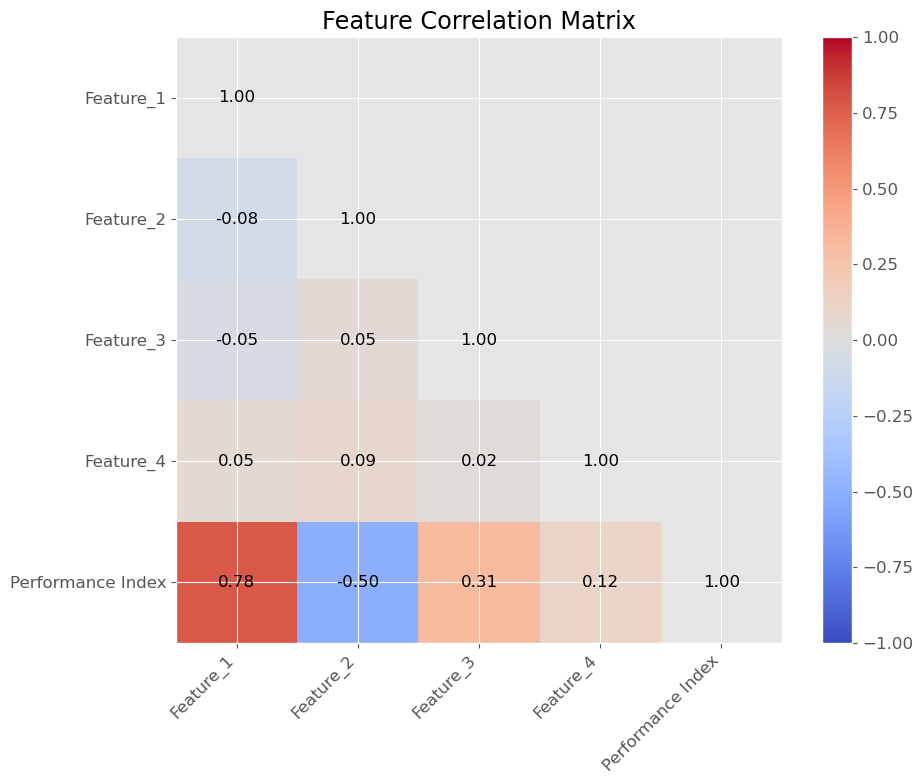

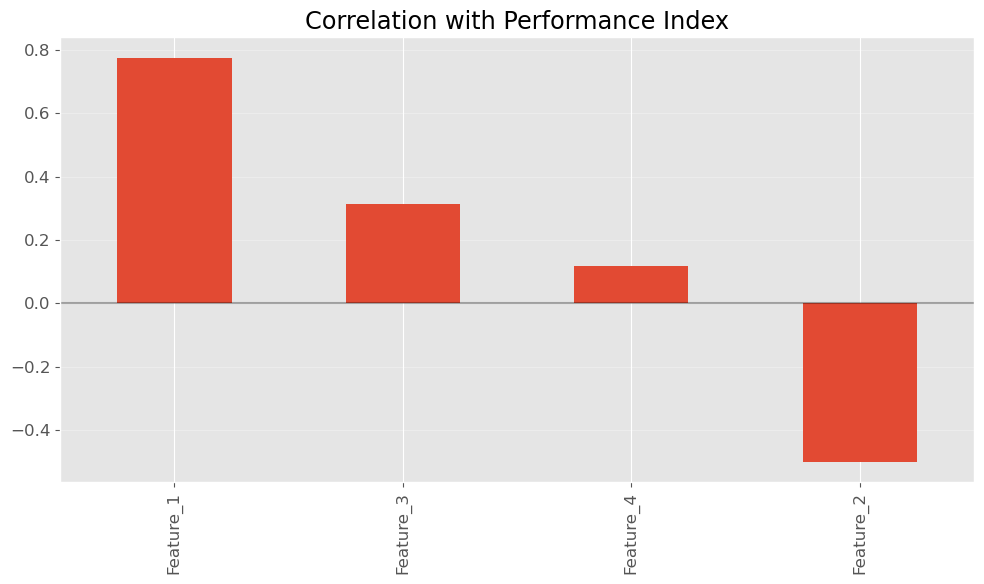

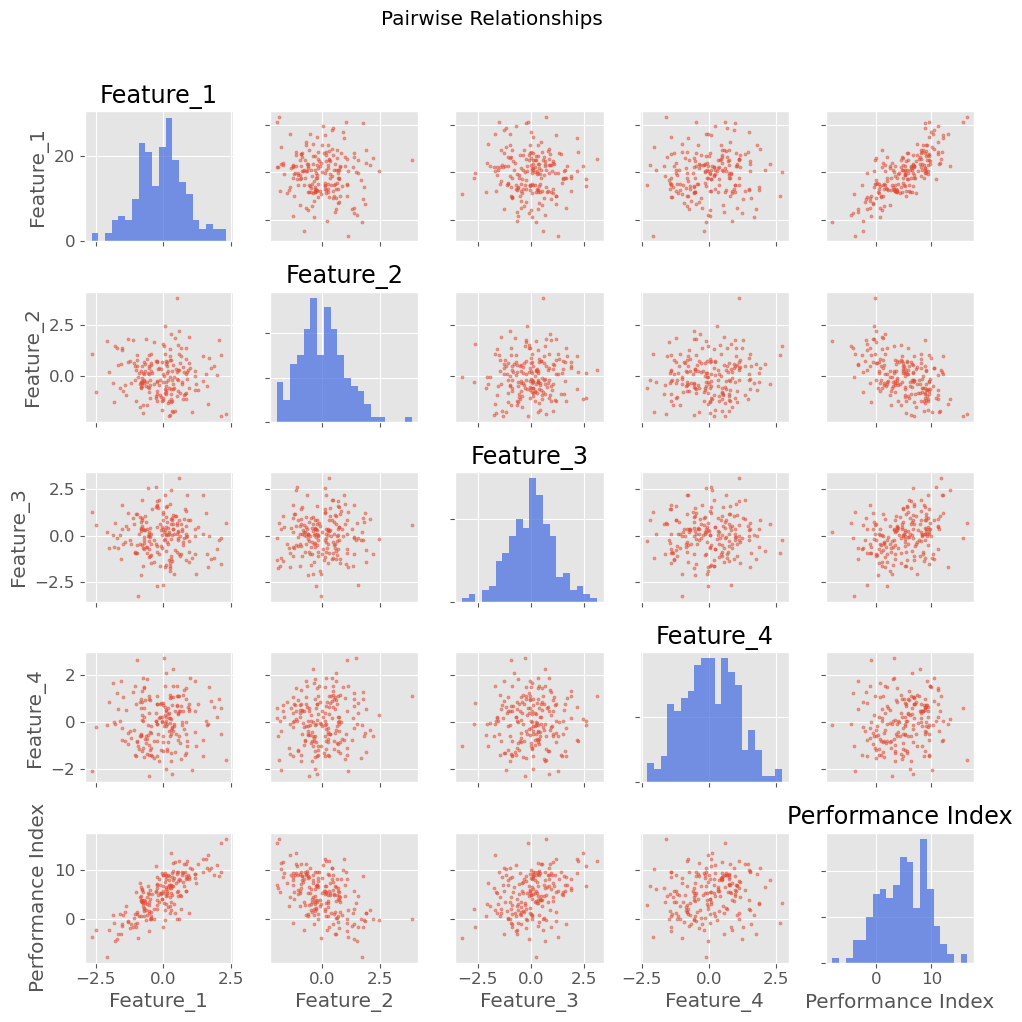

In [7]:
# Visualize the correlation matrix
plot_correlation_matrix(df, MLR_YCOL)

# Create pairplot for exploring relationships
plot_pairplot(df, MLR_YCOL)

## Prepare Data for Training

In [8]:
# Split features and target
X = df.drop(MLR_YCOL, axis=1).values
y = df[MLR_YCOL].values
feature_names = df.drop(MLR_YCOL, axis=1).columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the data (important for gradient descent)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared for training!")

Training set: 160 samples
Test set: 40 samples
Data prepared for training!


## Train the Multiple Linear Regression Model

In [9]:
# Initialize and train the model
mlr = MultipleLinearRegression(X_train_scaled, y_train, epochs=100, lr=0.01)
beta_history, loss_history = mlr.train(verbose=True)

# Plot learning curve
plot_learning_curve(loss_history)

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

## Visualize Weight Evolution

In [11]:
# Create and display weight evolution animation
weight_animation = create_weight_trajectory_animation(beta_history, feature_names)
weight_animation

## Feature Importance Visualization

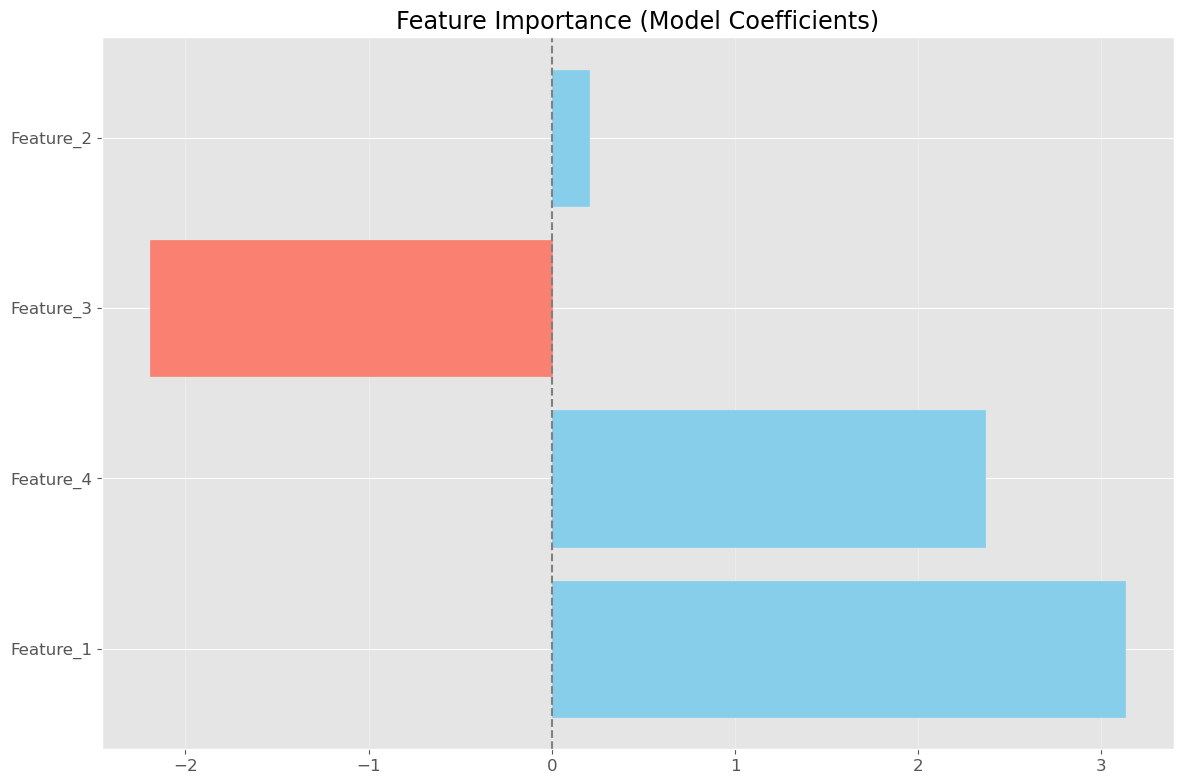

In [12]:
# Visualize feature importances
create_feature_importances_plot(mlr, feature_names)

## Evaluate Model Performance

Model Performance:

Training set MSE: 21.6496
Test set MSE: 31.2103

Training set R²: -0.3196
Test set R²: -0.2590


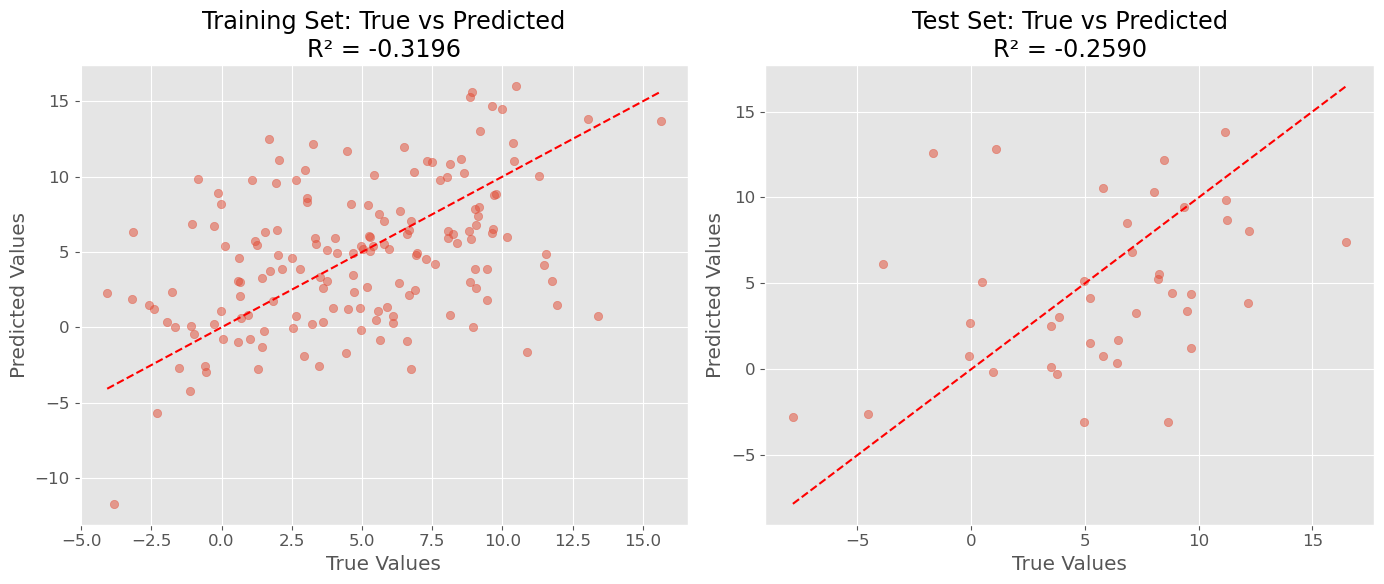

In [13]:
# Make predictions on test set
y_pred_train = mlr.predict(X_train_scaled)
y_pred_test = mlr.predict(X_test_scaled)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Model Performance:\n")
print(f"Training set MSE: {train_mse:.4f}")
print(f"Test set MSE: {test_mse:.4f}\n")
print(f"Training set R²: {train_r2:.4f}")
print(f"Test set R²: {test_r2:.4f}")

# Plot true vs predicted values
plt.figure(figsize=(14, 6))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f'Training Set: True vs Predicted\nR² = {train_r2:.4f}')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test Set: True vs Predicted\nR² = {test_r2:.4f}')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

## Residual Analysis

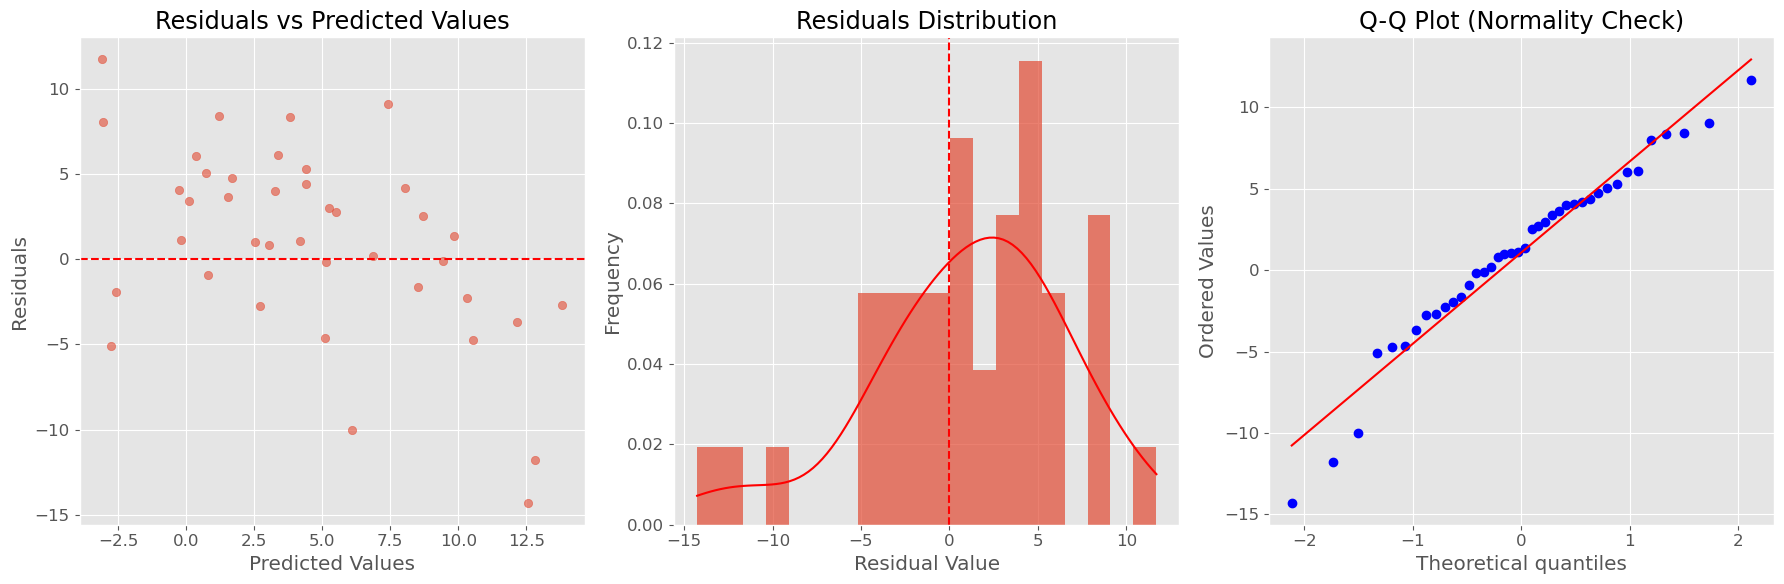

In [14]:
# Plot residuals analysis
plot_residuals(mlr, X_test_scaled, y_test)

## Compare with Statsmodels Implementation

In [15]:
# Add constant for intercept
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# Fit the statsmodels OLS model
sm_model = sm.OLS(y_train, X_train_sm).fit()

# Display the summary
print(sm_model.summary())

# Compare coefficients
print("\nCoefficient Comparison:\n")
print(f"{'Parameter':<15} {'Our Model':<15} {'Statsmodels':<15}")
print("-" * 45)
print(f"{'Intercept':<15} {mlr.beta[0]:<15.4f} {sm_model.params[0]:<15.4f}")

for i, feature in enumerate(feature_names):
    print(f"{feature:<15} {mlr.beta[i+1]:<15.4f} {sm_model.params[i+1]:<15.4f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     685.5
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.09e-97
Time:                        01:06:23   Log-Likelihood:                -216.60
No. Observations:                 160   AIC:                             443.2
Df Residuals:                     155   BIC:                             458.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7564      0.075     63.206      0.0

## 3D Visualization for Two-Feature Case

3D visualization is only available for datasets with exactly 2 features.
Creating partial dependence plots for the two most important features instead.


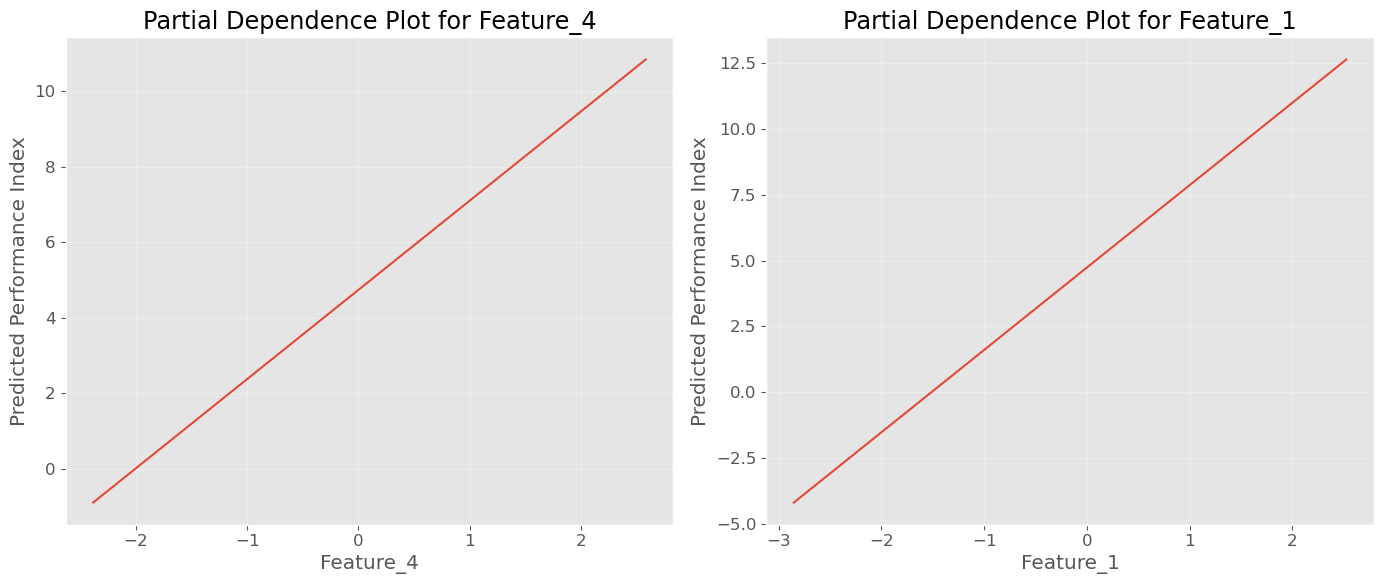

In [16]:
# This visualization only works well if we have exactly 2 features
if X.shape[1] == 2:
    # Create a meshgrid for the 3D surface
    x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
    y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    # Make predictions on the meshgrid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = mlr.predict(grid).reshape(xx.shape)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the data points
    ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train, 
              c='blue', marker='o', alpha=0.5, label='Training data')
    
    # Plot the regression surface
    surf = ax.plot_surface(xx, yy, Z, cmap='viridis', alpha=0.7, 
                          linewidth=0, antialiased=True, label='Regression plane')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Set labels and title
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(MLR_YCOL)
    ax.set_title('Multiple Linear Regression: Prediction Surface')
    
    plt.tight_layout()
    plt.show()
else:
    print("3D visualization is only available for datasets with exactly 2 features.")
    
    # If more than 2 features, we'll create a partial dependence plot for the two most important features
    if X.shape[1] > 2:
        print("Creating partial dependence plots for the two most important features instead.")
        
        # Get the two most important features based on coefficient magnitude
        feature_importance = np.abs(mlr.beta[1:])
        top_indices = np.argsort(feature_importance)[-2:]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # For each of the top two features
        for i, feature_idx in enumerate(top_indices):
            # Create a range of values for this feature
            feature_values = np.linspace(
                X_train_scaled[:, feature_idx].min(), 
                X_train_scaled[:, feature_idx].max(), 
                100
            )
            
            # Create predictions where only this feature varies
            predictions = []
            
            # Use the mean values for all other features
            X_mean = np.mean(X_train_scaled, axis=0)
            
            for value in feature_values:
                X_sample = X_mean.copy()
                X_sample[feature_idx] = value
                predictions.append(mlr.pred(X_sample))
            
            # Plot the partial dependence
            axes[i].plot(feature_values, predictions)
            axes[i].set_xlabel(feature_names[feature_idx])
            axes[i].set_ylabel(f'Predicted {MLR_YCOL}')
            axes[i].set_title(f'Partial Dependence Plot for {feature_names[feature_idx]}')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## Making Predictions with the Model

In [18]:
# Example of using the model for predictions
def make_prediction(input_data, feature_names, scaler, model):
    """
    Make a prediction using the trained model.
    
    Parameters:
    -----------
    input_data : dict
        Dictionary with feature names as keys and values as inputs
    feature_names : list
        List of feature names
    scaler : StandardScaler
        Fitted scaler for transforming inputs
    model : MultipleLinearRegression
        Trained model
    """
    # Convert input_data to a numpy array in the correct order
    input_array = np.array([input_data[feature] for feature in feature_names]).reshape(1, -1)
    
    # Scale the input
    input_scaled = scaler.transform(input_array)
    
    # Make prediction
    prediction = model.pred(input_scaled[0])
    
    return prediction

# Choose some example values from the test set
example_inputs = {}
for i, feature in enumerate(feature_names):
    # Use mean values for demonstration
    example_inputs[feature] = X_test[0, i]

# Make prediction
predicted_value = make_prediction(example_inputs, feature_names, scaler, mlr)
actual_value = y_test[0]

print(f"Prediction Example:")
print(f"Input values:")
for feature, value in example_inputs.items():
    print(f"  {feature}: {value:.4f}")

print(f"\nPredicted {MLR_YCOL}: {predicted_value:.4f}")
print(f"Actual {MLR_YCOL}: {actual_value:.4f}")
print(f"Absolute error: {abs(predicted_value - actual_value):.4f}")

Prediction Example:
Input values:
  Feature_1: -0.8397
  Feature_2: -0.5994
  Feature_3: -2.1239
  Feature_4: -0.5258

Predicted Performance Index: 5.0940
Actual Performance Index: 0.4597
Absolute error: 4.6343
